In [2]:
import pandas as pd
import random
import numpy as np
from random import randint
import torch
from transformers import AutoTokenizer, AutoModel
import gc

import scipy as sp
from scipy import sparse

import matplotlib.pyplot as plt
import matplotlib

import time
import pickle
import memory_profiler

%load_ext memory_profiler

from pathlib import Path
import distro

%load_ext watermark

In [3]:
torch.__version__

'2.1.1+cu121'

In [4]:
%load_ext autoreload
%autoreload 2

from text_embeddings_src.model_stuff import (
    train_loop,
    train_loop_with_projection_head,
)
from text_embeddings_src.data_stuff import (
    MultOverlappingSentencesPairDataset,
)

In [5]:
import jupyter_black

jupyter_black.load(line_length=79)

In [6]:
variables_path = Path("../../results/variables")
figures_path = Path("../../results/figures/updated_dataset")
data_path = Path("../../data")
# berenslab_data_path = Path("/gpfs01/berens/data/data/GPT_wiki_intro")

In [7]:
plt.style.use("../matplotlib_style.txt")

In [7]:
%watermark -a 'Rita González-Márquez' -t -d -tz -u -v -iv -w -m -h -p transformers,openTSNE
print(distro.name(pretty=True))

Author: Rita González-Márquez

Last updated: 2023-12-15 18:29:13CET

Python implementation: CPython
Python version       : 3.11.5
IPython version      : 8.18.1

transformers: 4.35.2
openTSNE    : 1.0.0

Compiler    : GCC 11.2.0
OS          : Linux
Release     : 3.10.0-1160.el7.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 64
Architecture: 64bit

Hostname: rgonzalesmarquez_GPU0-llm_gber7

distro         : 1.8.0
numpy          : 1.26.2
matplotlib     : 3.8.2
pandas         : 2.1.3
torch          : 2.1.1
scipy          : 1.11.4
jupyter_black  : 0.3.4
memory_profiler: 0.61.0

Watermark: 2.4.3

Ubuntu 22.04.3 LTS


# Import

In [13]:
%%time
iclr2024 = pd.read_parquet(
    data_path / "iclr2024.parquet.gzip",
    # index=False,
    engine="pyarrow",
    # compression="gzip",
)

CPU times: user 293 ms, sys: 76.9 ms, total: 370 ms
Wall time: 556 ms


In [14]:
iclr2024.keywords = iclr2024.keywords.transform(lambda x: list(x))
iclr2024.scores = iclr2024.scores.transform(lambda x: list(x))

In [15]:
iclr2024

,index,year,id,title,abstract,authors,decision,scores,keywords,gender-first,gender-last,t-SNE x,t-SNE y
0,0,2017,S1VaB4cex,FractalNet: Ultra-Deep Neural Networks without...,We introduce a design strategy for neural netw...,"Gustav Larsson, Michael Maire, Gregory Shakhna...",Accept (Poster),"[5, 7, 6, 6]",[],male,male,-28.117955,-20.418127
1,1,2017,H1W1UN9gg,Deep Information Propagation,We study the behavior of untrained neural netw...,"Samuel S. Schoenholz, Justin Gilmer, Surya Gan...",Accept (Poster),"[8, 9, 8]","[theory, deep learning]",male,None,-32.466820,-10.791123
2,2,2017,r1GKzP5xx,Recurrent Normalization Propagation,We propose a LSTM parametrization that preser...,"César Laurent, Nicolas Ballas, Pascal Vincent",Invite to Workshop Track,"[4, 6, 6]","[deep learning, optimization]",None,male,3.504240,19.946053
3,3,2017,S1J0E-71l,Surprisal-Driven Feedback in Recurrent Networks,Recurrent neural nets are widely used for pred...,"K, a, m, i, l, , R, o, c, k, i",Reject,"[3, 4, 3]","[unsupervised learning, applications, deep lea...",None,None,4.553473,16.037763
4,4,2017,SJGCiw5gl,Pruning Convolutional Neural Networks for Reso...,We propose a new formulation for pruning convo...,"Pavlo Molchanov, Stephen Tyree, Tero Karras, T...",Accept (Poster),"[6, 7, 9]","[deep learning, transfer learning]",None,male,-25.827705,-37.891772
...,...,...,...,...,...,...,...,...,...,...,...,...,...
24342,7299,2024,1bbPQShCT2,I-PHYRE: Interactive Physical Reasoning,Current evaluation protocols predominantly ass...,,,[],"[intuitive physics, physical reasoning]",None,None,43.137120,44.316133
24343,7300,2024,Ny150AblPu,EXPOSING TEXT-IMAGE INCONSISTENCY USING DIFFUS...,In the battle against widespread online misinf...,,,[],"[mis-contextualization, media forensic]",None,None,59.742172,-22.673627
24344,7301,2024,ZGBOfAQrMl,Video Super-Resolution Transformer with Masked...,"Recently, Vision Transformer has achieved grea...",,,[],"[video super-resolution, adaptive, memory and ...",None,None,57.933273,-3.932825
24345,7302,2024,J2kRjUAOLh,Contrastive Predict-and-Search for Mixed Integ...,Mixed integer linear programs (MILP) are flex...,,,[],[mixed integer programs; contrastive learning],None,None,-11.437999,21.289523


In [16]:
labels_iclr = np.load(variables_path / "updated_dataset" / "labels_iclr.npy")
colors_iclr = np.load(variables_path / "updated_dataset" / "colors_iclr.npy")

pickle_in = open(
    variables_path / "updated_dataset" / "dict_label_to_color.pkl", "rb"
)
dict_label_to_color = pickle.load(pickle_in)

# Layers exploration

In [12]:
model_names = [
    "BERT",
    "MPNet",
    "SBERT",
    "SciBERT",
    "SPECTER",
    "SciNCL",
    "SimCSE",
    "DeCLUTR",
    "DeCLUTR-sci",
    "SPECTER2",
]


model_paths = [
    "bert-base-uncased",
    "microsoft/mpnet-base",
    "sentence-transformers/all-mpnet-base-v2",
    "allenai/scibert_scivocab_uncased",
    "allenai/specter",
    "malteos/scincl",
    "princeton-nlp/unsup-simcse-bert-base-uncased",
    "johngiorgi/declutr-base",
    "johngiorgi/declutr-sci-base",
    "allenai/specter2_base",
]

In [8]:
seed = 42
# Set the random seed for PyTorch
torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

# Set the random seed for NumPy
np.random.seed(seed)

# Set the random seed
random.seed(seed)

In [27]:
# initialize
i = 1

# random_state = random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on device: {}".format(device))

tokenizer = AutoTokenizer.from_pretrained(model_paths[i])
model = AutoModel.from_pretrained(model_paths[i])
print(model_paths[i])

Running on device: cuda


Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['mpnet.pooler.dense.weight', 'mpnet.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


microsoft/mpnet-base


In [28]:
for name, param in model.named_parameters():
    print(f"{name}: {param.requires_grad}")

embeddings.word_embeddings.weight: True
embeddings.position_embeddings.weight: True
embeddings.LayerNorm.weight: True
embeddings.LayerNorm.bias: True
encoder.layer.0.attention.attn.q.weight: True
encoder.layer.0.attention.attn.q.bias: True
encoder.layer.0.attention.attn.k.weight: True
encoder.layer.0.attention.attn.k.bias: True
encoder.layer.0.attention.attn.v.weight: True
encoder.layer.0.attention.attn.v.bias: True
encoder.layer.0.attention.attn.o.weight: True
encoder.layer.0.attention.attn.o.bias: True
encoder.layer.0.attention.LayerNorm.weight: True
encoder.layer.0.attention.LayerNorm.bias: True
encoder.layer.0.intermediate.dense.weight: True
encoder.layer.0.intermediate.dense.bias: True
encoder.layer.0.output.dense.weight: True
encoder.layer.0.output.dense.bias: True
encoder.layer.0.output.LayerNorm.weight: True
encoder.layer.0.output.LayerNorm.bias: True
encoder.layer.1.attention.attn.q.weight: True
encoder.layer.1.attention.attn.q.bias: True
encoder.layer.1.attention.attn.k.weigh

In [8]:
# initialize
for i, model_name in enumerate(model_names):
    print(model_name)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # print("Running on device: {}".format(device))

    tokenizer = AutoTokenizer.from_pretrained(model_paths[i])
    model = AutoModel.from_pretrained(model_paths[i])
    # print(model_paths[i])
    for name, param in model.named_parameters():
        print(f"{name}: {param.requires_grad}")

    print("--------------------------------------")

BERT
embeddings.word_embeddings.weight: True
embeddings.position_embeddings.weight: True
embeddings.token_type_embeddings.weight: True
embeddings.LayerNorm.weight: True
embeddings.LayerNorm.bias: True
encoder.layer.0.attention.self.query.weight: True
encoder.layer.0.attention.self.query.bias: True
encoder.layer.0.attention.self.key.weight: True
encoder.layer.0.attention.self.key.bias: True
encoder.layer.0.attention.self.value.weight: True
encoder.layer.0.attention.self.value.bias: True
encoder.layer.0.attention.output.dense.weight: True
encoder.layer.0.attention.output.dense.bias: True
encoder.layer.0.attention.output.LayerNorm.weight: True
encoder.layer.0.attention.output.LayerNorm.bias: True
encoder.layer.0.intermediate.dense.weight: True
encoder.layer.0.intermediate.dense.bias: True
encoder.layer.0.output.dense.weight: True
encoder.layer.0.output.dense.bias: True
encoder.layer.0.output.LayerNorm.weight: True
encoder.layer.0.output.LayerNorm.bias: True
encoder.layer.1.attention.self.

Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['mpnet.pooler.dense.bias', 'mpnet.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


embeddings.word_embeddings.weight: True
embeddings.position_embeddings.weight: True
embeddings.LayerNorm.weight: True
embeddings.LayerNorm.bias: True
encoder.layer.0.attention.attn.q.weight: True
encoder.layer.0.attention.attn.q.bias: True
encoder.layer.0.attention.attn.k.weight: True
encoder.layer.0.attention.attn.k.bias: True
encoder.layer.0.attention.attn.v.weight: True
encoder.layer.0.attention.attn.v.bias: True
encoder.layer.0.attention.attn.o.weight: True
encoder.layer.0.attention.attn.o.bias: True
encoder.layer.0.attention.LayerNorm.weight: True
encoder.layer.0.attention.LayerNorm.bias: True
encoder.layer.0.intermediate.dense.weight: True
encoder.layer.0.intermediate.dense.bias: True
encoder.layer.0.output.dense.weight: True
encoder.layer.0.output.dense.bias: True
encoder.layer.0.output.LayerNorm.weight: True
encoder.layer.0.output.LayerNorm.bias: True
encoder.layer.1.attention.attn.q.weight: True
encoder.layer.1.attention.attn.q.bias: True
encoder.layer.1.attention.attn.k.weigh

In [12]:
model.encoder.layer[11]

BertLayer(
  (attention): BertAttention(
    (self): BertSelfAttention(
      (query): Linear(in_features=768, out_features=768, bias=True)
      (key): Linear(in_features=768, out_features=768, bias=True)
      (value): Linear(in_features=768, out_features=768, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (output): BertSelfOutput(
      (dense): Linear(in_features=768, out_features=768, bias=True)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (intermediate): BertIntermediate(
    (dense): Linear(in_features=768, out_features=3072, bias=True)
    (intermediate_act_fn): GELUActivation()
  )
  (output): BertOutput(
    (dense): Linear(in_features=3072, out_features=768, bias=True)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
)

In [29]:
model.pooler  # .layer[11]

MPNetPooler(
  (dense): Linear(in_features=768, out_features=768, bias=True)
  (activation): Tanh()
)

In [29]:
modules = [
    model.embeddings,
    *model.encoder.layer[:2],
]  # Replace 5 by what you want
for module in modules:
    for param in module.parameters():
        param.requires_grad = False

In [30]:
for name, param in model.named_parameters():
    print(f"{name}: {param.requires_grad}")

embeddings.word_embeddings.weight: False
embeddings.position_embeddings.weight: False
embeddings.token_type_embeddings.weight: False
embeddings.LayerNorm.weight: False
embeddings.LayerNorm.bias: False
encoder.layer.0.attention.self.query.weight: False
encoder.layer.0.attention.self.query.bias: False
encoder.layer.0.attention.self.key.weight: False
encoder.layer.0.attention.self.key.bias: False
encoder.layer.0.attention.self.value.weight: False
encoder.layer.0.attention.self.value.bias: False
encoder.layer.0.attention.output.dense.weight: False
encoder.layer.0.attention.output.dense.bias: False
encoder.layer.0.attention.output.LayerNorm.weight: False
encoder.layer.0.attention.output.LayerNorm.bias: False
encoder.layer.0.intermediate.dense.weight: False
encoder.layer.0.intermediate.dense.bias: False
encoder.layer.0.output.dense.weight: False
encoder.layer.0.output.dense.bias: False
encoder.layer.0.output.LayerNorm.weight: False
encoder.layer.0.output.LayerNorm.bias: False
encoder.layer.1

### exploration output

In [30]:
test_text = ["Hi my name is Rita."]

In [31]:
# preprocess the input
inputs = tokenizer(
    test_text,
    padding=True,
    truncation=True,
    return_tensors="pt",
    max_length=512,
).to(device)

In [32]:
inputs

{'input_ids': tensor([[    0,  7636,  2030,  2175,  2007, 11624,  1016,     2]],
       device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1]], device='cuda:0')}

In [34]:
model.to(device)

MPNetModel(
  (embeddings): MPNetEmbeddings(
    (word_embeddings): Embedding(30527, 768, padding_idx=1)
    (position_embeddings): Embedding(514, 768, padding_idx=1)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): MPNetEncoder(
    (layer): ModuleList(
      (0-11): 12 x MPNetLayer(
        (attention): MPNetAttention(
          (attn): MPNetSelfAttention(
            (q): Linear(in_features=768, out_features=768, bias=True)
            (k): Linear(in_features=768, out_features=768, bias=True)
            (v): Linear(in_features=768, out_features=768, bias=True)
            (o): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (intermediate): MPNetIntermediate(
          (dense): Linear(in_

In [35]:
model(**inputs)  # [0].shape  # [1].shape

BaseModelOutputWithPooling(last_hidden_state=tensor([[[-0.1944,  0.2234, -0.0105,  ...,  0.1301, -0.0548,  0.0220],
         [-0.0627, -0.2211, -0.0483,  ...,  0.0552, -0.0270, -0.0104],
         [-0.1352,  0.0082,  0.0685,  ..., -0.0541,  0.0621,  0.0774],
         ...,
         [ 0.0301,  0.4014,  0.0188,  ...,  0.1003, -0.0244, -0.0517],
         [ 0.0797,  0.0526,  0.0305,  ...,  0.0518, -0.1234, -0.0463],
         [ 0.0103,  0.4551,  0.0095,  ...,  0.0741, -0.1618,  0.0528]]],
       device='cuda:0', grad_fn=<NativeLayerNormBackward0>), pooler_output=tensor([[ 0.1421, -0.0403,  0.0245, -0.0105,  0.0191, -0.1390, -0.0840,  0.0648,
          0.0033,  0.0307, -0.0077,  0.0265, -0.0257, -0.0424,  0.0317, -0.0537,
         -0.1393, -0.1608, -0.0270, -0.0185,  0.0355, -0.0515, -0.0617,  0.0763,
         -0.0769, -0.0263, -0.0543,  0.1073,  0.0768, -0.0264, -0.0008,  0.0354,
          0.0311,  0.0679,  0.0668,  0.0498, -0.0157, -0.0352,  0.0495, -0.0952,
         -0.0282,  0.0049, -0.054

In [ ]:

# # inference
# outputs = model(**inputs)[0].cpu().detach() 

# embedding_av = torch.mean(outputs, [0, 1]).numpy()
# embedding_sep = outputs[:, -1, :].numpy()
# embedding_cls = outputs[:, 0, :].numpy()

# Adding projector

In [17]:
# pooling functions
def mean_pool(token_embeds, attention_mask):
    # reshape attention_mask to cover 768-dimension embeddings
    in_mask = attention_mask.unsqueeze(-1).expand(token_embeds.size())
    # perform mean-pooling but exclude padding tokens (specified by in_mask)
    pool = torch.sum(token_embeds * in_mask, 1) / torch.clamp(
        in_mask.sum(1), min=1e-9
    )
    return pool


def sep_pool(token_embeds, attention_mask):
    ix = attention_mask.sum(1) - 1
    ix0 = torch.arange(attention_mask.size(0))
    return token_embeds[ix0, ix, :]


def cls_pool(token_embeds, attention_mask):
    ix0 = torch.arange(attention_mask.size(0))
    return token_embeds[ix0, 0, :]


def seventh_pool(token_embeds, attention_mask):
    ix0 = torch.arange(attention_mask.size(0))
    return token_embeds[ix0, 7, :]

In [18]:
import torch
import torch.nn as nn
from transformers import AutoModel
import adapters
from adapters import AutoAdapterModel


class CustomModel(nn.Module):
    def __init__(self, checkpoint, in_dim=768, feat_dim=128, hidden_dim=512):
        super(CustomModel, self).__init__()

        self.in_dim = in_dim
        self.feat_dim = feat_dim
        self.hidden_dim = hidden_dim

        # Load Model with given checkpoint and extract its body
        if checkpoint == "allenai/specter2_base":
            self.model = AutoAdapterModel.from_pretrained(checkpoint)
            # add adapter proximity
            self.model.load_adapter(
                "allenai/specter2",
                source="hf",
                load_as="specter2",
                set_active=True,
            )
        else:
            self.model = AutoModel.from_pretrained(
                checkpoint
            )  # ,config=AutoConfig.from_pretrained(checkpoint, output_attentions=True,output_hidden_states=True))

        # add projection head
        self.projection_head = nn.Sequential(
            nn.Linear(self.in_dim, self.hidden_dim),
            nn.ReLU(inplace=True),
            nn.Linear(self.hidden_dim, self.feat_dim),
        )

    def forward(self, input_ids=None, attention_mask=None, optimized_rep="av"):
        # Extract outputs from the body
        outputs = self.model(
            input_ids=input_ids, attention_mask=attention_mask
        )[0]

        # pooling
        if optimized_rep == "av":
            h = mean_pool(outputs, attention_mask)

        elif optimized_rep == "cls":
            h = cls_pool(outputs, attention_mask)

        elif optimized_rep == "sep":
            h = sep_pool(outputs, attention_mask)

        elif optimized_rep == "7th":
            h = seventh_pool(outputs, attention_mask)

        # Add custom layers
        z = self.projection_head(h)  # .view(-1,768)

        return z, h

In [21]:
model_test = CustomModel(model_paths[0])

In [24]:
model_test  # .projection_head

CustomModel(
  (model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affi

In [25]:
for name, param in model_test.named_parameters():
    print(f"{name}: {param.requires_grad}")

model.embeddings.word_embeddings.weight: True
model.embeddings.position_embeddings.weight: True
model.embeddings.token_type_embeddings.weight: True
model.embeddings.LayerNorm.weight: True
model.embeddings.LayerNorm.bias: True
model.encoder.layer.0.attention.self.query.weight: True
model.encoder.layer.0.attention.self.query.bias: True
model.encoder.layer.0.attention.self.key.weight: True
model.encoder.layer.0.attention.self.key.bias: True
model.encoder.layer.0.attention.self.value.weight: True
model.encoder.layer.0.attention.self.value.bias: True
model.encoder.layer.0.attention.output.dense.weight: True
model.encoder.layer.0.attention.output.dense.bias: True
model.encoder.layer.0.attention.output.LayerNorm.weight: True
model.encoder.layer.0.attention.output.LayerNorm.bias: True
model.encoder.layer.0.intermediate.dense.weight: True
model.encoder.layer.0.intermediate.dense.bias: True
model.encoder.layer.0.output.dense.weight: True
model.encoder.layer.0.output.dense.bias: True
model.encode

### sanity check output

In [53]:
test_text = ["Hi my name is Rita."]

In [55]:
# preprocess the input
old_model = AutoModel.from_pretrained(model_paths[0])
tokenizer = AutoTokenizer.from_pretrained(model_paths[0])
inputs = tokenizer(
    test_text,
    padding=True,
    truncation=True,
    return_token_type_ids=False,
    return_tensors="pt",
    max_length=512,
).to(device)

In [56]:
inputs

{'input_ids': tensor([[  101,  7632,  2026,  2171,  2003, 11620,  1012,   102]],
       device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1]], device='cuda:0')}

In [57]:
model_test.to(device)

CustomModel(
  (model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affi

In [58]:
old_model.to(device)

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
  

In [62]:
# TEST
old_model(**inputs)[0]  # == model_test.model(**inputs)[0]

tensor([[[ 0.1286,  0.2925,  0.1487,  ..., -0.2231,  0.3022,  0.9385],
         [ 0.6235,  0.2482,  0.2557,  ..., -0.0574,  0.8209,  0.3311],
         [-0.2326, -0.2783, -0.4162,  ..., -0.0133,  0.0898,  0.2336],
         ...,
         [ 0.5914, -0.2341,  0.6581,  ...,  0.2008,  1.1242,  1.4513],
         [ 0.3857, -0.1003, -0.3692,  ...,  0.5074, -0.0274, -0.4099],
         [ 0.8128, -0.1049, -0.2351,  ...,  0.4146, -0.3801, -0.1596]]],
       device='cuda:0', grad_fn=<NativeLayerNormBackward0>)

In [60]:
model_test.model(**inputs)[0]

tensor([[[ 0.1286,  0.2925,  0.1487,  ..., -0.2231,  0.3022,  0.9385],
         [ 0.6235,  0.2482,  0.2557,  ..., -0.0574,  0.8209,  0.3311],
         [-0.2326, -0.2783, -0.4162,  ..., -0.0133,  0.0898,  0.2336],
         ...,
         [ 0.5914, -0.2341,  0.6581,  ...,  0.2008,  1.1242,  1.4513],
         [ 0.3857, -0.1003, -0.3692,  ...,  0.5074, -0.0274, -0.4099],
         [ 0.8128, -0.1049, -0.2351,  ...,  0.4146, -0.3801, -0.1596]]],
       device='cuda:0', grad_fn=<NativeLayerNormBackward0>)

In [63]:
# TEST
model_test(**inputs)[1] == mean_pool(
    old_model(**inputs)[0], inputs["attention_mask"]
)

tensor([[True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, T

# Run 7

In [14]:
model_names = [
    "BERT",
    # "MPNet",
    "SBERT",
    "SciBERT",
    "SPECTER",
    "SciNCL",
    "SimCSE",
    "DeCLUTR",
    "DeCLUTR-sci",
    # "SPECTER2",
]


model_paths = [
    "bert-base-uncased",
    # "microsoft/mpnet-base",
    "sentence-transformers/all-mpnet-base-v2",
    "allenai/scibert_scivocab_uncased",
    "allenai/specter",
    "malteos/scincl",
    "princeton-nlp/unsup-simcse-bert-base-uncased",
    "johngiorgi/declutr-base",
    "johngiorgi/declutr-sci-base",
    # "allenai/specter2_base",
]

In [ ]:
%%time
for i, model_name in enumerate(model_names):
    ## fix random seeds
    seed = 42
    # Set the random seed for PyTorch
    torch.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    # torch.use_deterministic_algorithms(True)
    # Set the random seed for NumPy
    np.random.seed(seed)
    # Set the random seed
    random.seed(seed)

    # set up model
    print("Model (+ projection head): ", model_name)

    device = "cuda" if torch.cuda.is_available() else "cpu"
    print("Running on device: {}".format(device))

    tokenizer = AutoTokenizer.from_pretrained(model_paths[i])
    model = CustomModel(model_paths[i])
    print(model_paths[i])

    # data
    training_dataset = MultOverlappingSentencesPairDataset(
        iclr2024.abstract, tokenizer, device, n_cons_sntcs=2, seed=42
    )

    gen = torch.Generator()
    gen.manual_seed(seed)
    training_loader = torch.utils.data.DataLoader(
        training_dataset, batch_size=64, shuffle=True, generator=gen
    )
    print("Training loader length: ", len(training_loader))

    losses, knn_accuracies = train_loop_with_projection_head(
        model,
        training_loader,
        device,
        iclr2024.abstract.to_list(),
        tokenizer,
        (labels_iclr != "unlabeled"),
        labels_acc=labels_iclr[labels_iclr != "unlabeled"],
        n_epochs=2,
        lr=2e-5,
    )

    # save
    saving_path = Path("embeddings_" + model_name.lower()) / Path(
        "updated_dataset"
    )
    (variables_path / saving_path).mkdir(exist_ok=True)

    np.save(
        variables_path / saving_path / "losses_train_with_projector_head_run7",
        losses,
    )
    np.save(
        variables_path
        / saving_path
        / "knn_accuracies_train_with_projector_head_run7",
        knn_accuracies,
    )

Model (+ projection head):  BERT
Running on device: cuda
bert-base-uncased
Training loader length:  368


  0%|          | 0/368 [00:00<?, ?it/s]

In [19]:
model_names = [
    # "BERT",
    # # "MPNet",
    # "SBERT",
    # "SciBERT",
    # "SPECTER",
    # "SciNCL",
    # "SimCSE",
    # "DeCLUTR",
    # "DeCLUTR-sci",
    "SPECTER2",
]


model_paths = [
    # "bert-base-uncased",
    # # "microsoft/mpnet-base",
    # "sentence-transformers/all-mpnet-base-v2",
    # "allenai/scibert_scivocab_uncased",
    # "allenai/specter",
    # "malteos/scincl",
    # "princeton-nlp/unsup-simcse-bert-base-uncased",
    # "johngiorgi/declutr-base",
    # "johngiorgi/declutr-sci-base",
    "allenai/specter2_base",
]

In [20]:
%%time
for i, model_name in enumerate(model_names):
    ## fix random seeds
    seed = 42
    # Set the random seed for PyTorch
    torch.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    # torch.use_deterministic_algorithms(True)
    # Set the random seed for NumPy
    np.random.seed(seed)
    # Set the random seed
    random.seed(seed)

    # set up model
    print("Model (+ projection head): ", model_name)

    device = "cuda" if torch.cuda.is_available() else "cpu"
    print("Running on device: {}".format(device))

    tokenizer = AutoTokenizer.from_pretrained(model_paths[i])
    model = CustomModel(model_paths[i])
    print(model_paths[i])

    # data
    training_dataset = MultOverlappingSentencesPairDataset(
        iclr2024.abstract, tokenizer, device, n_cons_sntcs=2, seed=42
    )

    gen = torch.Generator()
    gen.manual_seed(seed)
    training_loader = torch.utils.data.DataLoader(
        training_dataset, batch_size=64, shuffle=True, generator=gen
    )
    print("Training loader length: ", len(training_loader))

    losses, knn_accuracies = train_loop_with_projection_head(
        model,
        training_loader,
        device,
        iclr2024.abstract.to_list(),
        tokenizer,
        (labels_iclr != "unlabeled"),
        labels_acc=labels_iclr[labels_iclr != "unlabeled"],
        n_epochs=2,
        lr=2e-5,
    )

    # save
    saving_path = Path("embeddings_" + model_name.lower()) / Path(
        "updated_dataset"
    )
    (variables_path / saving_path).mkdir(exist_ok=True)

    np.save(
        variables_path / saving_path / "losses_train_with_projector_head_run7",
        losses,
    )
    np.save(
        variables_path
        / saving_path
        / "knn_accuracies_train_with_projector_head_run7",
        knn_accuracies,
    )

Model (+ projection head):  SPECTER2
Running on device: cuda


Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

README.md:   0%|          | 0.00/9.67k [00:00<?, ?B/s]

allenai/specter2_base
Training loader length:  368


  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

CPU times: user 8min 51s, sys: 13min 42s, total: 22min 34s
Wall time: 17min 30s


In [43]:
%%time
# WITH LR=2e-4

i = 1
model_name = model_names[i]

## fix random seeds
seed = 42
# Set the random seed for PyTorch
torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
# torch.use_deterministic_algorithms(True)
# Set the random seed for NumPy
np.random.seed(seed)
# Set the random seed
random.seed(seed)

# set up model
print("Model (+ projection head): ", model_name)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device: {}".format(device))

tokenizer = AutoTokenizer.from_pretrained(model_paths[i])
model = CustomModel(model_paths[i])
print(model_paths[i])

# data
training_dataset = MultOverlappingSentencesPairDataset(
    iclr2024.abstract, tokenizer, device, n_cons_sntcs=2, seed=42
)

gen = torch.Generator()
gen.manual_seed(seed)
training_loader = torch.utils.data.DataLoader(
    training_dataset, batch_size=64, shuffle=True, generator=gen
)
print("Training loader length: ", len(training_loader))

losses, knn_accuracies = train_loop_with_projection_head(
    model,
    training_loader,
    device,
    iclr2024.abstract.to_list(),
    tokenizer,
    (labels_iclr != "unlabeled"),
    labels_acc=labels_iclr[labels_iclr != "unlabeled"],
    n_epochs=2,
    lr=2e-5,
)

# save
saving_path = Path("embeddings_" + model_name.lower()) / Path(
    "updated_dataset"
)
(variables_path / saving_path).mkdir(exist_ok=True)

np.save(
    variables_path / saving_path / "losses_train_with_projector_head_run7_v1",
    losses,
)
np.save(
    variables_path
    / saving_path
    / "knn_accuracies_train_with_projector_head_run7_v1",
    knn_accuracies,
)

Model (+ projection head):  MPNet
Running on device: cuda


Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['mpnet.pooler.dense.weight', 'mpnet.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


microsoft/mpnet-base
Training loader length:  368


  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

CPU times: user 16min 3s, sys: 14min 33s, total: 30min 37s
Wall time: 17min 43s


## Plot

In [ ]:
model_names = [
    "BERT",
    "MPNet",
    "SBERT",
    "SciBERT",
    "SPECTER",
    "SciNCL",
    "SimCSE",
    "DeCLUTR",
    "DeCLUTR-sci",
    # "SPECTER2",
]

In [ ]:
%matplotlib inline

fig, axs = plt.subplots(2, 2, figsize=(6, 4), dpi=200)
n_epochs = 2
colormap = plt.get_cmap("tab10")

# for i, model_name in enumerate(model_names):
#     # load things
saving_path = Path("embeddings_" + model_name.lower()) / Path(
    "updated_dataset"
)

losses = np.load(
    variables_path / saving_path / "losses_train_with_projector_head_run7.npy"
)
knn_accuracies = np.load(
    variables_path
    / saving_path
    / "knn_accuracies__train_with_projector_head_run7.npy"
)

saving_name_2 = Path("knn_accuracy_" + model_name.lower() + ".npy")
knn_acc_highd = np.load(variables_path / "updated_dataset" / saving_name_2)

color = colormap(i)

axs[0, 0].plot(
    np.arange(n_epochs),
    np.mean(losses, axis=1),
    label=model_name,
    color=color,
)
axs[0, 0].set_xticks(np.arange(n_epochs))
axs[0, 0].set_xlabel("Epochs")
axs[0, 0].set_ylabel("Loss")
axs[0, 0].legend()

axs[0, 1].plot(
    np.arange(n_epochs),
    knn_accuracies[:, 0],
    label=f"({knn_accuracies[0, 0]:.3f}, {knn_accuracies[-1, 0]:.3f})",
    color=color,
)
axs[0, 1].scatter(-0.4, knn_acc_highd[0], c=color, s=5)
axs[0, 1].text(
    -0.3,
    knn_acc_highd[0],
    f"{knn_acc_highd[0]:.3f}",
    fontsize=5,
    va="center",
    ha="left",
)
axs[0, 1].set_xticks(np.arange(n_epochs))
axs[0, 1].set_ylim(0.2, 0.65)
axs[0, 1].set_xlabel("Epochs")
axs[0, 1].set_ylabel("kNN accuracy [AV]")
axs[0, 1].legend(loc="lower right")

axs[1, 0].plot(
    np.arange(n_epochs),
    knn_accuracies[:, 1],
    label=f"({knn_accuracies[0, 1]:.3f}, {knn_accuracies[-1, 1]:.3f})",
    color=color,
)
axs[1, 0].scatter(-0.4, knn_acc_highd[1], c=color, s=5)
axs[1, 0].set_xticks(np.arange(n_epochs))
axs[1, 0].set_ylim(0.2, 0.65)
axs[1, 0].set_xlabel("Epochs")
axs[1, 0].set_ylabel("kNN accuracy [CLS]")
axs[1, 0].legend()

axs[1, 1].plot(
    np.arange(n_epochs),
    knn_accuracies[:, 2],
    label=model_name,
    color=color,
)
axs[1, 1].scatter(-0.4, knn_acc_highd[2], c=color, s=5)
axs[1, 1].set_xticks(np.arange(n_epochs))
axs[1, 1].set_ylim(0.2, 0.65)
axs[1, 1].set_xlabel("Epochs")
axs[1, 1].set_ylabel("kNN accuracy [SEP]")

fig.savefig(figures_path / "loss_and_knn_accuracy_training_run7_v1.png")

### Fancy plot

In [21]:
model_names = [
    "BERT",
    "MPNet",
    "SBERT",
    "SciBERT",
    "SPECTER",
    "SciNCL",
    "SimCSE",
    "DeCLUTR",
    "DeCLUTR-sci",
    "SPECTER2",
]

In [22]:
colormap = plt.get_cmap("tab10")
dict_original_colors = dict()
for i, model_name in enumerate(model_names):
    color = colormap(i)
    dict_original_colors[model_name] = colormap(i)

In [23]:
# new order
model_names = [
    "MPNet",
    "BERT",
    "SciBERT",
    "SimCSE",
    "DeCLUTR",
    "DeCLUTR-sci",
    "SciNCL",
    "SPECTER",
    "SPECTER2",
    "SBERT",
]

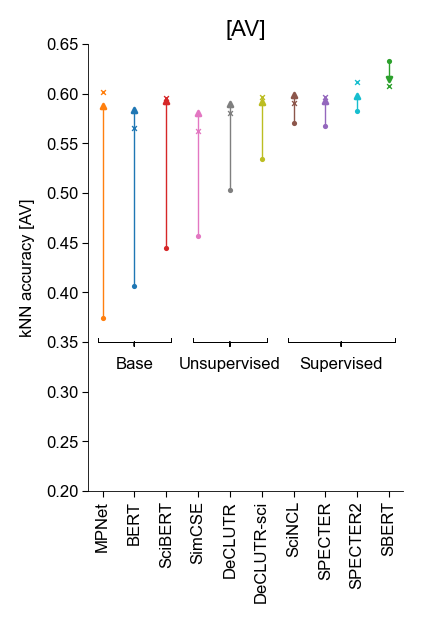

In [24]:
%matplotlib inline

fig, ax = plt.subplots(figsize=(2, 3), dpi=200)

rep = 0  # av

for i, model_name in enumerate(model_names):
    # load things
    saving_path = Path("embeddings_" + model_name.lower()) / Path(
        "updated_dataset"
    )

    losses = np.load(variables_path / saving_path / "losses_run1.npy")
    knn_accuracies_after = np.load(
        variables_path / saving_path / "knn_accuracies_run1.npy"
    )

    saving_name_2 = Path("knn_accuracy_" + model_name.lower() + ".npy")
    knn_accuracies_before = np.load(
        variables_path / "updated_dataset" / saving_name_2
    )
    # NEW ACCURACIES WITH PROJECTION HEAD
    # if model_name != "SPECTER2":
    knn_accuracies_run7 = np.load(
        variables_path
        / saving_path
        / "knn_accuracies_train_with_projector_head_run7.npy"
    )
    # knn_accuracies_run7_v2 = np.load(
    #     variables_path
    #     / saving_path
    #     / "knn_accuracies_train_with_projector_head_run7_v2.npy"
    # )

    color = dict_original_colors[model_name]

    ax.plot(
        np.ones(2) * i,
        np.array([knn_accuracies_before[rep], knn_accuracies_after[0, rep]]),
        label=f"{model_name}",
        color=color,
        # marker=".",
        # ms=3,
    )
    ax.scatter(
        i,
        knn_accuracies_before[rep],
        color=color,
        marker=".",
        s=3,
    )
    if knn_accuracies_before[rep] <= knn_accuracies_after[0, rep]:
        ax.scatter(
            i,
            knn_accuracies_after[0, rep],
            color=color,
            marker="^",
            s=3,
        )
    else:
        ax.scatter(
            i,
            knn_accuracies_after[0, rep],
            color=color,
            marker="v",
            s=3,
        )
    # NEW ACCURACIES WITH PROJECTION HEAD
    # if model_name != "SPECTER2":
    ax.scatter(
        i,
        knn_accuracies_run7[0, rep],
        color=color,
        marker="x",
        s=3,
    )
    # ax.scatter(
    #     i,
    #     knn_accuracies_run7_v2[0, rep],
    #     color=color,
    #     marker="*",
    #     s=3,
    # )

    ax.set_xticks(np.arange(len(model_names)))
    ax.set_xticklabels(model_names, rotation="vertical")
    ax.set_ylim(0.2, 0.65)
    ax.set_ylabel("kNN accuracy [AV]")
    # ax.legend(loc="lower right")
    ax.set_title("[AV]")
    ax.annotate(
        "Base",
        xy=(1, 0.35),
        xytext=(1, 0.32),
        xycoords="data",
        fontsize=6,
        ha="center",
        va="bottom",
        bbox=dict(boxstyle="square", fc="white", edgecolor="None"),
        arrowprops=dict(
            arrowstyle="-[, widthB=2.2, lengthB=0.25", lw=0.35, color="k"
        ),
    )

    ax.annotate(
        "Unsupervised",
        xy=(4, 0.35),
        xytext=(4, 0.32),
        xycoords="data",
        fontsize=6,
        ha="center",
        va="bottom",
        bbox=dict(boxstyle="square", fc="white", edgecolor="None"),
        arrowprops=dict(
            arrowstyle="-[, widthB=2.2, lengthB=0.25", lw=0.35, color="k"
        ),
    )

    ax.annotate(
        "Supervised",
        xy=(7.5, 0.35),
        xytext=(7.5, 0.32),
        xycoords="data",
        fontsize=6,
        ha="center",
        va="bottom",
        bbox=dict(boxstyle="square", fc="white", edgecolor="None"),
        arrowprops=dict(
            arrowstyle="-[, widthB=3.2, lengthB=0.25", lw=0.35, color="k"
        ),
    )


fig.savefig(
    figures_path / "loss_and_knn_accuracy_training_run1_and_run7_v3.png"
)